In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np
from pathlib import Path
import csv
import os
import scipy
import scipy.integrate as integrate
# %matplotlib inline
%matplotlib widget


In [34]:
path = r'C:\Users\Manvydas\Desktop\FTMC\Duomenys'
dates = '20230620_TIPS-NPH_IR-C'
used = set()
df = pd.DataFrame()
pathfullsphere = path + '\\' + dates
#pathfullspectra = path + '\\' + dates + '\\' + 'spektrai'
names = os.listdir(pathfullsphere)
namesspectra = [x for x in names if 'S_' in x]  

print(len(namesspectra), namesspectra)


2 ['S_TIPS-NPH1E-2M_Ir-C1E-4M.txp', 'S_TIPS-NPH1E-3M_Ir-C1E-4M.txp']


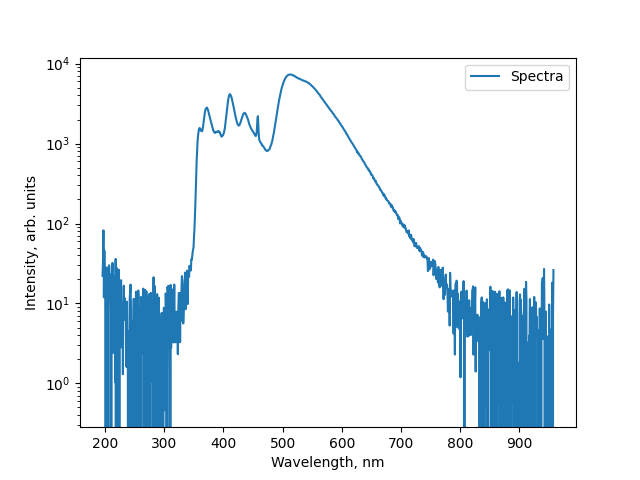

In [35]:
f = 0
plt.close()
df['WL'] = pd.read_csv(pathfullsphere + '\\' +
                       namesspectra[f], usecols=['@0'], sep='\t')
df['S'] = pd.read_csv(pathfullsphere + '\\' +
                      namesspectra[f], usecols=['0.000000'], sep='\t')
plt.plot(df['WL'], df['S'], label='Spectra')
plt.xlabel('Wavelength, nm'); plt.ylabel('Intensity, arb. units')
plt.yscale('log')
plt.legend()
plt.show()


A_TIPS-NPH1E-3M_Ir-C1E-4M_exp20ms_avg100x_@450nm.txp
B_TIPS-NPH1E-3M_Ir-C1E-4M_exp20ms_avg100x_@450nm.txp
C_TIPS-NPH1E-3M_Ir-C1E-4M_exp20ms_avg100x_@450nm.txp
Sample  S_TIPS-NPH1E-3M_Ir-C1E-4M.txp  absorbed  35.6  and has a QY of  1.37  with corr  1.44 QY with Pb 1.36  with corr 1.42


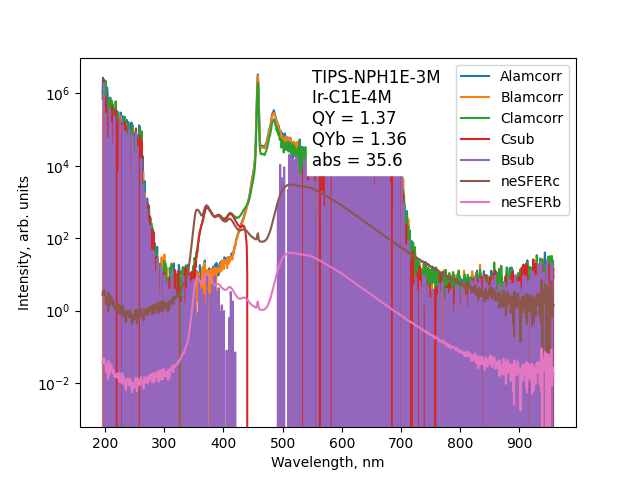

In [53]:
filtercorr = pd.read_csv('C:\\Users\\Manvydas\\Desktop\\FTMC\\Projects\\DPA40\\FC6.csv',
                         delimiter=';', index_col=None, header=None)
filtercorr.columns = ['WL', 'corr']
spherecorr = pd.read_csv('C:\\Users\\Manvydas\\Desktop\\Qy_Calculator\\corrections\\Z_Edinburg2019Stepono.dat',
                         delimiter='\t', index_col=None, header=0)
spherecorr.columns = ['WL', 'corr']
df = pd.DataFrame()
df['corr'] = filtercorr['corr'] / spherecorr['corr']
# df['corr'] = 1 / spherecorr['corr']



integrate_from_spectra = 330 #350
integrate_to_spectra = 446 #520
integrate_from_laser = 450 #525 
integrate_to_laser = 460 #540
f = 1
measurement = 'C'
comment = '' + measurement
coff = 0.024
coff2 = 1

abscorr = 1.6

namecrop = "B_" + namesspectra[f].split('_')[1]# + "_" + namesspectra[f].split('_')[2]
# print(namecrop)
namessph = [x for x in names if namecrop in x]
namessph = namessph[0]
# print(namecrop)
# df = pd.DataFrame() #'WL', 'A', 'B', 'C', 'S'


plt.close()
df['WL'] = pd.read_csv(pathfullsphere + '\\' +
                       namesspectra[f], usecols=['@0'], sep='\t')
df['S'] = pd.read_csv(pathfullsphere + '\\' +
                      namesspectra[f], usecols=['0.000000'], sep='\t')
df['A'] = pd.read_csv(pathfullsphere + '\\' +
                      namessph.replace('B_', 'A_'), usecols=['0.000000'], sep='\t')
df['B'] = pd.read_csv(pathfullsphere + '\\' + namessph,
                      usecols=['0.000000'], sep='\t')
# df['C'] = pd.read_csv(pathfullsphere + '\\' + namessph.replace('B_', 'C_'), usecols = ['0.000000'], sep='\t')
df['C'] = pd.read_csv(pathfullsphere + '\\' + namessph.replace('B_', 'C_').replace('C_TIPS', str(measurement) + '_TIPS'), usecols=['0.000000'], sep='\t')
# df['corr'] = df['corr'].fillna(1E-4)
df['Alamcorr'] = df['A'] * df['WL'] / df['corr'] / 200
df['Blamcorr'] = df['B'] * df['WL'] / df['corr'] / 200
df['Clamcorr'] = df['C'] * df['WL'] / df['corr'] / 200
df['neSFER'] = df['S'] * df['WL'] * coff / 200
df['Csub'] = df['Clamcorr'] - df['Alamcorr']
df['Bsub'] = df['Blamcorr'] - df['Alamcorr']


dfS = df.copy()
dfS = dfS[dfS['WL'] < integrate_to_spectra]
dfS = dfS[dfS['WL'] > integrate_from_spectra]
# print(dfS)
c = max(dfS['Csub']) / max(dfS['Bsub'])
Pc = float(np.trapz(dfS['neSFER'], x=dfS['WL']))
Pb = float(np.trapz(dfS['neSFER']/c*coff2, x=dfS['WL']))

plt.yscale('log')
plt.plot(df['WL'], df['Alamcorr'], label='Alamcorr')
plt.plot(df['WL'], df['Blamcorr'], label='Blamcorr')
plt.plot(df['WL'], df['Clamcorr'], label='Clamcorr')
plt.plot(df['WL'], df['Csub'], label='Csub')
plt.plot(df['WL'], df['Bsub'], label='Bsub')
plt.plot(df['WL'], df['neSFER'], label='neSFERc')
plt.plot(df['WL'], df['neSFER']/c*coff2, label='neSFERb')
# plt.xlim(400, 510)
# plt.ylim(1E1, 1E5)




dfL = df.copy()
dfL = dfL[dfL['WL'] < integrate_to_laser]
dfL = dfL[dfL['WL'] > integrate_from_laser]
Lc = float(np.trapz(dfL['Clamcorr'], x=dfL['WL']))
Lb = float(np.trapz(dfL['Blamcorr'], x=dfL['WL']))
La = float(np.trapz(dfL['Alamcorr'], x=dfL['WL']))
abs = round(1 - (Lc/Lb), 3)
qy = round(100*(Pc/(La*(abs))), 2)
qy2 = round(100*(Pc/(La*(abs-abscorr/100))), 2)
qy3 = round(100*((Pc-(1-abs)*Pb)/(La*abs)), 2)
qy4 = round(100*((Pc-(1-(abs-abscorr/100))*Pb)/(La*(abs-abscorr/100))), 2)

print(namessph.replace('B_', 'A_'))
print(namessph)
print(namessph.replace('B_', 'C_').replace(
    '_tecoflex', str(measurement) + '_tecoflex'))

print('Sample ', namesspectra[f], ' absorbed ', round(
    abs*100, 2), ' and has a QY of ', qy, ' with corr ', qy2, 'QY with Pb', qy3, ' with corr', qy4)
message = '%s \n%s \nQY = %s \nQYb = %s \nabs = %s'%(namesspectra[f].split('_')[1], namesspectra[f].split('_')[2].replace('.txp',''), qy, qy3, abs*100)
plt.xlabel('Wavelength, nm'); plt.ylabel('Intensity, arb. units')
plt.text(550, 1E4, message, fontsize = 12, backgroundcolor = 'w')
plt.legend()
plt.show()


# THIS SECTION WRITES USER PARAMETERS FILE
now = datetime.datetime.now()
now = now.strftime("%Y/%m/%d, %H:%M:%S")
headerList = ['Time', 'Sample', 'comment', 'La', 'Lb', 'Lc', 'Pc', 'Pb', 'abs', 'abscorr', 'qy',
              'qy2', 'qy3', 'qy4', 'P integrate from', 'P integrate to', 'L integrate from', 'Pc integrate to']
parameters_list = [now, namesspectra[f], comment, La, Lb, Lc, Pc, Pb, round(
    abs*100, 2), abscorr, qy, qy2, qy3, qy4, integrate_from_spectra, integrate_to_spectra, integrate_from_laser, integrate_to_laser]
csvname = os.path.join(path + "\\" + dates + "\\" + 'QY.csv')
if not os.path.exists(csvname):
    with open(csvname, 'a', newline='') as csvfile:
        resultwriter = csv.writer(csvfile, delimiter=';')
        resultwriter.writerow(headerList)
    with open(csvname, 'a', newline='') as csvfile:
        resultwriter = csv.writer(csvfile, delimiter=';')
        resultwriter.writerow(parameters_list)
else:
    with open(csvname, 'a', newline='') as csvfile:
        resultwriter = csv.writer(csvfile, delimiter=';')
        resultwriter.writerow(parameters_list)
    # print(df)

    # df = pd.read_csv(pathfullspectra + '\\' + f + namerest, usecols = ['0.000000'], sep='\t')
